In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
file_path=r"C:\Users\sneha\Downloads\COE_PROJ\Data\cleaned_dataset.csv"
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    model_data = df[['Income', 'Disposable_Income', 'Essential_Expenses', 'Non_Essential_Expenses',
                     'Total_Expenses_to_Income_Ratio', 'Desired_Savings_Percentage', 'Savings_Efficiency',
                     'Potential_Savings_Groceries', 'Potential_Savings_Transport',
                     'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment']].copy()

    model_data['Calculated_Savings_Efficiency'] = (
    model_data['Disposable_Income'] / (model_data['Income'] * model_data['Desired_Savings_Percentage'])).clip(0, 1)

    # Create target variable
    model_data['Savings_Target_Achieved'] = (
        (model_data['Calculated_Savings_Efficiency'] >= model_data['Desired_Savings_Percentage'] * 0.5) |
        (model_data['Disposable_Income'] >= model_data['Income'] * 0.1) |
        (model_data['Total_Expenses_to_Income_Ratio'] <= 0.7) |
        (model_data[['Potential_Savings_Groceries', 'Potential_Savings_Transport',
                     'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment']].sum(axis=1) > 500)
    ).astype(int)

    return model_data

In [3]:
def train_model(model_data):
    X = model_data[['Income', 'Disposable_Income', 'Essential_Expenses', 'Non_Essential_Expenses',
                    'Total_Expenses_to_Income_Ratio', 'Desired_Savings_Percentage', 'Calculated_Savings_Efficiency',
                    'Potential_Savings_Groceries', 'Potential_Savings_Transport',
                    'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment']]
    y = model_data['Savings_Target_Achieved']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight="balanced")
    dt_model.fit(X_train, y_train)

    joblib.dump(dt_model, 'decision_tree_model.pkl')
    print("Model saved as 'decision_tree_model.pkl'")

    return dt_model, X_train, X_test, y_train, y_test  # Ensure five values are returned

In [4]:
def evaluate_model(model, X_test, y_test, model_data, feature_columns):
    y_pred = model.predict(X_test)

    with open("eval_metrics.txt", "w") as file:
        accuracy = accuracy_score(y_test, y_pred)
        classification = classification_report(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)

        file.write(f"Model Accuracy: {accuracy:.4f}\n")
        file.write("\nClassification Report:\n")
        file.write(classification + "\n")
        file.write("\nConfusion Matrix:\n")
        file.write(str(confusion) + "\n\n")

        print(f"Model Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", classification)
        print("\nConfusion Matrix:\n", confusion)

        importance = model.feature_importances_
        importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': importance})
        importance_df.sort_values(by='Importance', ascending=False, inplace=True)

        file.write("Feature Importance:\n")
        file.write(importance_df.to_string(index=False) + "\n")

        print("\nFeature Importance:\n", importance_df)

        plt.figure(figsize=(8, 5))
        plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
        plt.title("Feature Importance")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.show()

        print("\nSavings Efficiency Scores:")
        print(model_data[['Income', 'Calculated_Savings_Efficiency']].head())

In [5]:
def predict_new_data(file_path):
    dt_model = joblib.load('decision_tree_model.pkl')
    model_data = preprocess_data(file_path)

    X = model_data[['Income', 'Disposable_Income', 'Essential_Expenses', 'Non_Essential_Expenses',
                    'Total_Expenses_to_Income_Ratio', 'Desired_Savings_Percentage', 'Calculated_Savings_Efficiency',
                    'Potential_Savings_Groceries', 'Potential_Savings_Transport',
                    'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment']]

    model_data['Predicted_Savings_Target_Achieved'] = dt_model.predict(X)

    # Save predictions including Savings Efficiency Score
    model_data[['Savings_Target_Achieved', 'Predicted_Savings_Target_Achieved', 'Calculated_Savings_Efficiency']].to_csv('predictions.csv', index=False)
    print("Predictions saved to 'predictions.csv' with Savings Efficiency Score.")

In [6]:
data_path = r"C:\Users\sneha\Downloads\COE_PROJ\Data\cleaned_dataset.csv" # Update with your dataset's location
model_data = preprocess_data(data_path)    # Preprocess and get the structured data
print(model_data.head())                   # Preview the processed data

          Income  Disposable_Income  Essential_Expenses  \
0   44637.249636       11265.627707        24508.650001   
1   26858.596592        9676.818733        10953.658450   
2   50367.605084       13891.450624        24027.439185   
3  101455.600247       31617.953615        47417.599430   
4   24875.283548        6265.700532        13383.780612   

   Non_Essential_Expenses  Total_Expenses_to_Income_Ratio  \
0             4019.511102                        0.698187   
1             2263.854847                        0.607338   
2             3865.492522                        0.680484   
3            10424.499110                        0.640164   
4             1868.524377                        0.722552   

   Desired_Savings_Percentage  Savings_Efficiency  \
0                   13.890948            0.252382   
1                    7.160376            0.360288   
2                   13.997808            0.275801   
3                   16.455440            0.311643   
4            

In [7]:
dt_model, X_train, X_test, y_train, y_test = train_model(model_data)

Model saved as 'decision_tree_model.pkl'


In [8]:
print(model_data.columns)

Index(['Income', 'Disposable_Income', 'Essential_Expenses',
       'Non_Essential_Expenses', 'Total_Expenses_to_Income_Ratio',
       'Desired_Savings_Percentage', 'Savings_Efficiency',
       'Potential_Savings_Groceries', 'Potential_Savings_Transport',
       'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment',
       'Calculated_Savings_Efficiency', 'Savings_Target_Achieved'],
      dtype='object')


Model Accuracy: 0.9960

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.91      0.80        35
           1       1.00      1.00      1.00      3963

    accuracy                           1.00      3998
   macro avg       0.86      0.96      0.90      3998
weighted avg       1.00      1.00      1.00      3998


Confusion Matrix:
 [[  32    3]
 [  13 3950]]

Feature Importance:
                             Feature  Importance
1                 Disposable_Income    0.918440
7       Potential_Savings_Groceries    0.040199
4    Total_Expenses_to_Income_Ratio    0.035699
8       Potential_Savings_Transport    0.004653
9      Potential_Savings_Eating_Out    0.001009
0                            Income    0.000000
2                Essential_Expenses    0.000000
3            Non_Essential_Expenses    0.000000
5        Desired_Savings_Percentage    0.000000
6     Calculated_Savings_Efficiency    0.000000
10  Potential_Savings_Entert

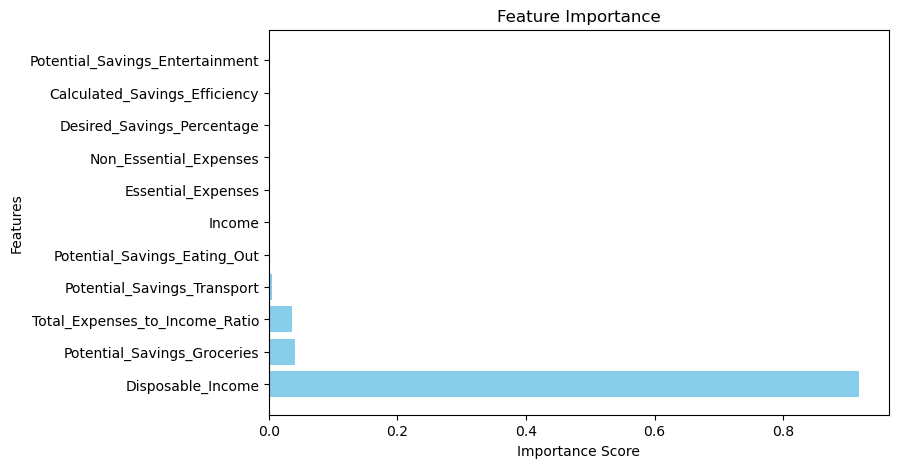


Savings Efficiency Scores:
          Income  Calculated_Savings_Efficiency
0   44637.249636                       0.018169
1   26858.596592                       0.050317
2   50367.605084                       0.019703
3  101455.600247                       0.018939
4   24875.283548                       0.033433


In [9]:
feature_columns = ['Income', 'Disposable_Income', 'Essential_Expenses', 'Non_Essential_Expenses',
                   'Total_Expenses_to_Income_Ratio', 'Desired_Savings_Percentage', 'Calculated_Savings_Efficiency',
                   'Potential_Savings_Groceries', 'Potential_Savings_Transport',
                   'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment']


y_pred = evaluate_model(dt_model, X_test, y_test, model_data, feature_columns)  # Pass all required arguments

In [10]:
predict_new_data(data_path)  # Predict savings targets and save results

Predictions saved to 'predictions.csv' with Savings Efficiency Score.


In [11]:
print(model_data['Calculated_Savings_Efficiency'].describe())

count    19986.000000
mean         0.029552
std          0.015395
min          0.000077
25%          0.017918
50%          0.027521
75%          0.039006
max          0.094620
Name: Calculated_Savings_Efficiency, dtype: float64


In [12]:
sample_data = model_data.sample(n=2)  # Select 2 random rows from your dataset
print(sample_data)

             Income  Disposable_Income  Essential_Expenses  \
6785   51994.543780       14909.912475        22641.157773   
11142  62173.136021        7332.990346        43982.853199   

       Non_Essential_Expenses  Total_Expenses_to_Income_Ratio  \
6785              6334.637018                        0.691487   
11142             4362.368744                        0.839140   

       Desired_Savings_Percentage  Savings_Efficiency  \
6785                    14.504491            0.286759   
11142                   11.080485            0.117945   

       Potential_Savings_Groceries  Potential_Savings_Transport  \
6785                    619.091434                   674.137453   
11142                   981.056754                   747.344294   

       Potential_Savings_Eating_Out  Potential_Savings_Entertainment  \
6785                     129.666291                       636.329607   
11142                    445.548187                       370.152554   

       Calculated_Savings_

In [13]:
# Define an unusual input, simulating a new financial scenario
out_of_box_input = pd.DataFrame({
    'Income': [250000],  # Very high income
    'Disposable_Income': [150000],  # Large disposable income
    'Essential_Expenses': [50000],  # High essential expenses
    'Non_Essential_Expenses': [30000],  # Unusually structured non-essentials
    'Total_Expenses_to_Income_Ratio': [0.32],  # Low expense ratio
    'Desired_Savings_Percentage': [0.15],  # Slightly higher than typical
    'Calculated_Savings_Efficiency': [0.1],  # Higher efficiency
    'Potential_Savings_Groceries': [500],
    'Potential_Savings_Transport': [700],
    'Potential_Savings_Eating_Out': [1200],
    'Potential_Savings_Entertainment': [1500]
})
print(out_of_box_input)

   Income  Disposable_Income  Essential_Expenses  Non_Essential_Expenses  \
0  250000             150000               50000                   30000   

   Total_Expenses_to_Income_Ratio  Desired_Savings_Percentage  \
0                            0.32                        0.15   

   Calculated_Savings_Efficiency  Potential_Savings_Groceries  \
0                            0.1                          500   

   Potential_Savings_Transport  Potential_Savings_Eating_Out  \
0                          700                          1200   

   Potential_Savings_Entertainment  
0                             1500  


In [14]:
dataset_preds = dt_model.predict(sample_data[feature_columns])
out_of_box_preds = dt_model.predict(out_of_box_input[feature_columns])

print("Dataset Predictions:", dataset_preds)
print("Out-of-Box Predictions:", out_of_box_preds)

Dataset Predictions: [1 1]
Out-of-Box Predictions: [1]


In [15]:
test_low_income = pd.DataFrame({
    'Income': [18000], 'Disposable_Income': [2000], 'Essential_Expenses': [15000],
    'Non_Essential_Expenses': [2000], 'Total_Expenses_to_Income_Ratio': [0.95],
    'Desired_Savings_Percentage': [0.2], 'Calculated_Savings_Efficiency': [0.02],
    'Potential_Savings_Groceries': [50], 'Potential_Savings_Transport': [40],
    'Potential_Savings_Eating_Out': [30], 'Potential_Savings_Entertainment': [10]
})
print("Prediction:", dt_model.predict(test_low_income))

Prediction: [1]


In [16]:
# Simulating a financially struggling user scenario
low_savings_input = pd.DataFrame({
    'Income': [15000],  # Low income
    'Disposable_Income': [1000],  # Minimal disposable income
    'Essential_Expenses': [12000],  # High essential expenses
    'Non_Essential_Expenses': [3000],  # Uncontrolled spending
    'Total_Expenses_to_Income_Ratio': [0.95],  # Expenses take up most of income
    'Desired_Savings_Percentage': [0.2],  # Wants to save 20% but can't
    'Calculated_Savings_Efficiency': [0.01],  # Almost no efficiency in savings
    'Potential_Savings_Groceries': [50],
    'Potential_Savings_Transport': [40],
    'Potential_Savings_Eating_Out': [30],
    'Potential_Savings_Entertainment': [10]
})

# Predict savings achievement
prediction = dt_model.predict(low_savings_input[feature_columns])
print("Prediction:", prediction)

Prediction: [0]
